In [1]:
import pathlib as pl
import shutil
import dakota.environment as dakenv
import sys, os
import numpy as np

# script_dir = pl.Path(__file__).parent
script_dir = pl.Path(os.getcwd())  ## how resilient is this?
print(script_dir)
sys.path.append(script_dir)

from utils import funs_create_dakota_conf, funs_data_processing

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation


In [2]:
data_dir = script_dir / "Norm20DPosition"
TRAINING_SAMPLES_FILE = data_dir / "train_Norm20DPosition_1000LHS.dat"
TEST_SAMPLES_FILE = data_dir / "test_Norm20DPosition_100LHS.dat"

## Load & process input data

In [3]:
tmp_folder = script_dir / ".tmp_output"
if tmp_folder.exists():
    shutil.rmtree(tmp_folder)
tmp_folder.mkdir()
TRAINING_SAMPLES_FILE = shutil.copy(TRAINING_SAMPLES_FILE, tmp_folder)
TEST_SAMPLES_FILE = shutil.copy(TEST_SAMPLES_FILE, tmp_folder)

In [4]:
PROCESSED_TRAINING_FILE = funs_data_processing.process_input_file(TRAINING_SAMPLES_FILE)
PROCESSED_TEST_FILE = funs_data_processing.process_input_file(
    TEST_SAMPLES_FILE,
    columns_to_remove=[
        "interface",
        "AFmax_4um",
        "GAFmax_4um",
    ],  # remove the output column; needs to be evaluated
)

In [5]:
variables_train = funs_data_processing.get_variable_names(PROCESSED_TRAINING_FILE)
print(variables_train)
variables_test = funs_data_processing.get_variable_names(PROCESSED_TEST_FILE)
print(variables_test)

['%eval_id', 'RELDEPTH', 'DIAMETER', 'POSITION', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF', 'AFmax_4um', 'GAFmax_4um']
['%eval_id', 'RELDEPTH', 'DIAMETER', 'POSITION', 'ANGLE', 'ELECTRELDEPTH', 'THICKNESS_SKIN', 'THICKNESS_SCT', 'THICKNESS_APONEUROSIS', 'THICKNESS_LOOSE_AREOLAR_TISSUE', 'THICKNESS_SKULL_OUTER', 'THICKNESS_SKULL_DIPLOE', 'THICKNESS_SKULL_INNER', 'THICKNESS_CSF', 'CONDUCTIVITY_SKIN', 'CONDUCTIVITY_SCT', 'CONDUCTIVITY_APONEUROSIS', 'CONDUCTIVITY_LOOSE_AREOLAR_TISSUE', 'CONDUCTIVITY_SKULL_CORTICAL', 'CONDUCTIVITY_SKULL_DIPLOE', 'CONDUCTIVITY_CSF']


## Plot input data (Fig03 & Fig07)

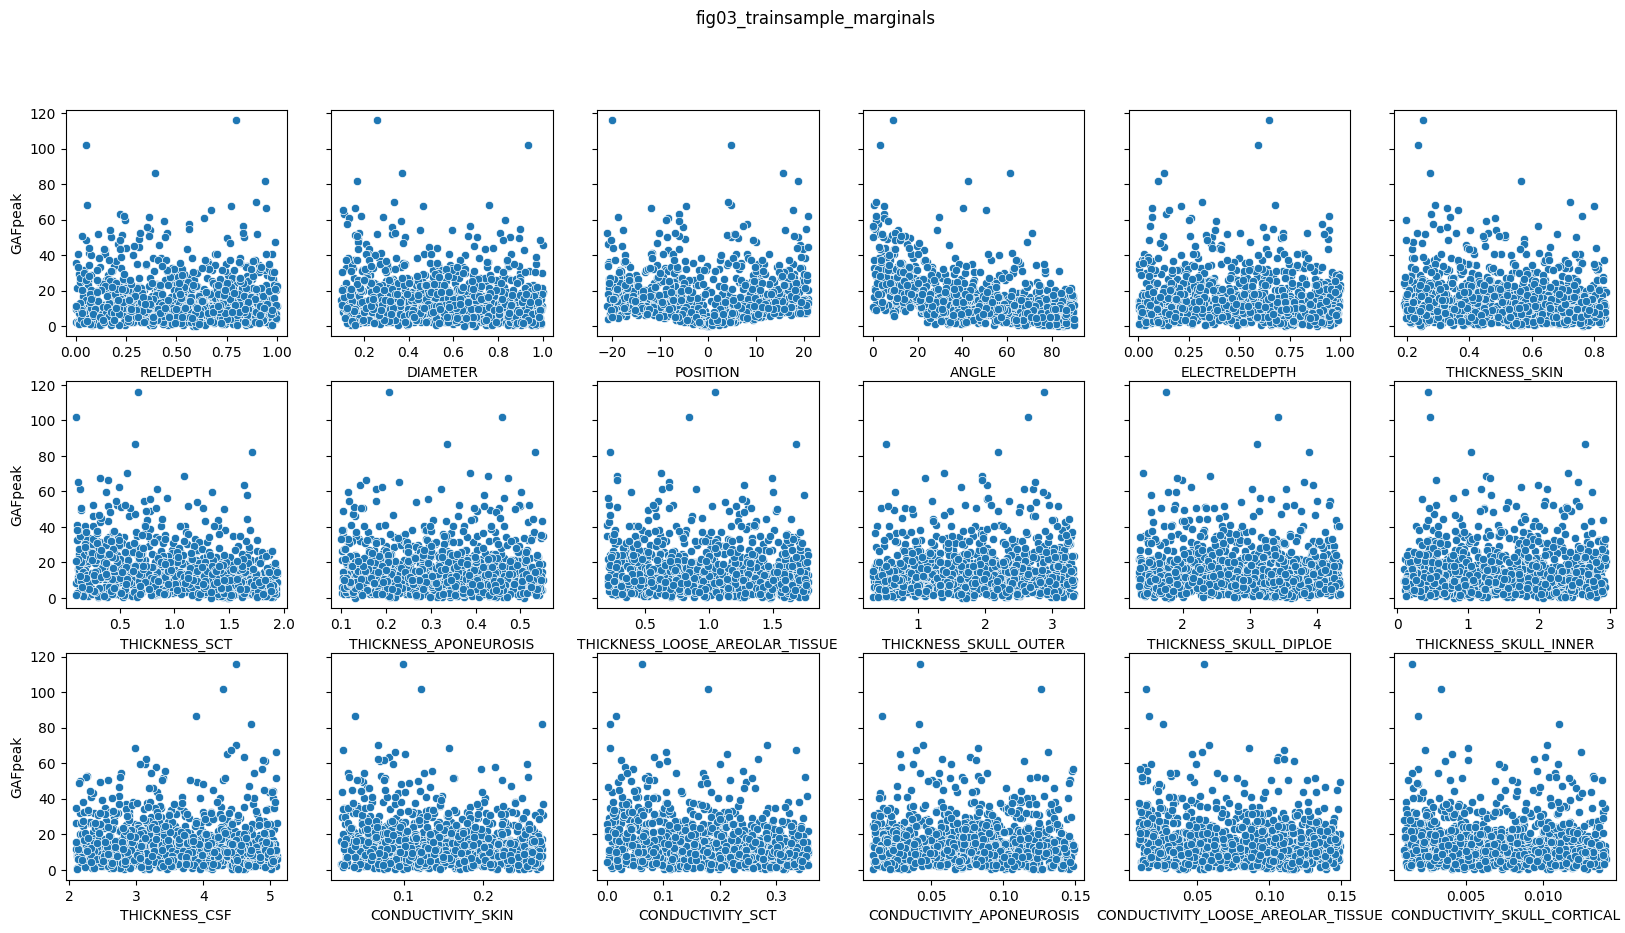

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

title = "fig03_trainsample_marginals"
fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
data = funs_data_processing.load_data(PROCESSED_TRAINING_FILE)
data = data.astype(np.float64)
data.rename(columns={"GAFmax_4um": "GAFpeak"}, inplace=True)
data.head()
axs: List[plt.Axes] = axs.flatten()
# fig, axs = plt.subplots(1,1, figsize=(15, 15), sharey=True)
# axs = [axs]
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="GAFpeak", ax=ax)
    # plt.scatter(data[c].values, data["AFpeak"].values)
    ax.set_xlabel(c)
    # ax.hlines(0.0, data[c].min(), data[c].max(), color="black", linestyle="--")
plt.suptitle(title)
plt.show()

## Create & run Dakota study

In [7]:
N_RESPONSES = 2

dakota_conf_path = tmp_folder / "dakota.in"
dakota_conf = funs_create_dakota_conf.start_dakota_file()
dakota_conf += funs_create_dakota_conf.add_surrogate_model(
    PROCESSED_TRAINING_FILE, cross_validation_folds=5
)
dakota_conf += funs_create_dakota_conf.add_evaluation_method(PROCESSED_TEST_FILE)
dakota_conf += funs_create_dakota_conf.add_variables(
    variables=variables_train[1:-N_RESPONSES],
)
dakota_conf += funs_create_dakota_conf.add_responses(variables_train[-N_RESPONSES:])
print(dakota_conf)
funs_create_dakota_conf.write_to_file(dakota_conf, dakota_conf_path)


    environment
        tabular_data
            tabular_data_file = 'results.dat'
    

        model
            id_model 'SURR_MODEL'
            surrogate global
                gaussian_process surfpack
                
                cross_validation folds = 5 
                metrics = "root_mean_squared" "sum_abs" "mean_abs" "max_abs" "rsquared"
                
                import_build_points_file 
                    '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_Norm20DPosition_1000LHS_processed.txt'
                    custom_annotated header eval_id
                export_approx_points_file "predictions.dat"
                export_approx_variance_file "variances.dat"
        
        method
            id_method "EVALUATION"
            output debug
            model_pointer 'SURR_MODEL'
        
            list_parameter_study
                import_points_file 
                    ## this file should be wo

In [8]:
os.chdir(tmp_folder)
shutil.copy(script_dir / "execute_dakota.py", tmp_folder)
!python execute_dakota.py
os.chdir(script_dir)

/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output
Dakota version 6.19+ (stable) released Aug  8 2024.
Repository revision 494027b (2024-04-29) built Aug  8 2024 14:37:02.
Running serial Dakota executable in serial mode.
Start time: Thu Sep 12 08:05:09 2024

Using provided Dakota input string
Writing new restart file 'dakota.rst'.
Surrogate model retrieving points with 20 variables and 2 response
functions from file '/home/ordonez/osparc-services/osparc-dakota-examples/workflows/jupyter_sumo_evaluation/.tmp_output/train_Norm20DPosition_1000LHS_processed.txt'
Variables read:
                      3.1620873640e-01 RELDEPTH
                      1.7286298620e-01 DIAMETER
                     -4.6848993470e+00 POSITION
                      6.5205218360e+00 ANGLE
                      9.4016965000e-01 ELECTRELDEPTH
                      5.7569280520e-01 THICKNESS_SKIN
                      7.7414113040e-01 THICKNESS_SCT
                      

## Evaluate Dakota predictions

In [9]:
RESPONSE = "GAFmax_4um"

y = funs_data_processing.get_results(TEST_SAMPLES_FILE, RESPONSE)
y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
std = np.sqrt(
    funs_data_processing.get_results(
        tmp_folder / "variances.dat", RESPONSE + "_variance"
    )
)
y_tilde = (y - y_hat) / std

k =  1.5
The data IS normally distributed. p-value: 0.8765292982166897


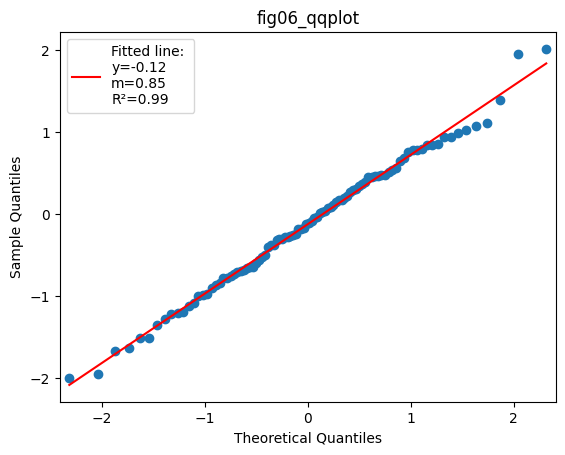

k =  None
The data is NOT normally distributed. p-value: 1.0289638426513812e-06


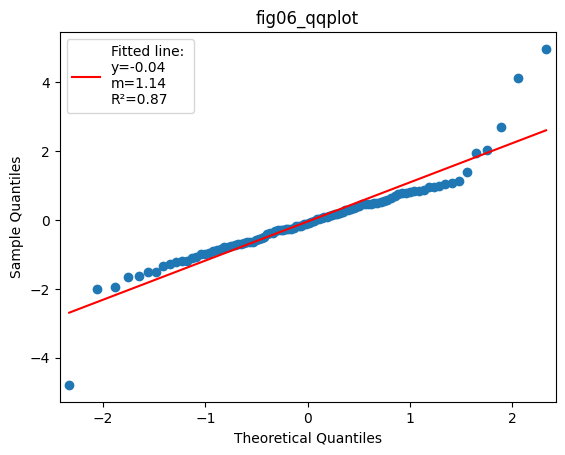

In [10]:
from utils import funs_gp_evaluation
import matplotlib.pyplot as plt

for k in [1.5, None]:  # outlier detection threshold
    print("k = ", k)
    pval = funs_gp_evaluation.test_normality(y_tilde, k)
    slope, intercept, r2 = funs_gp_evaluation.make_qqplot(y_tilde, k, MAKEPLOT=True)
    plt.title("fig06_qqplot")
    plt.show()

In [11]:
data = funs_data_processing.load_data(PROCESSED_TEST_FILE)
data = data.astype(np.float64)
data["y"] = y
data["y_hat"] = y_hat
data["res"] = y - y_hat
data["ares"] = np.abs(y - y_hat)
data["nres"] = y_tilde
data["anres"] = np.abs(y_tilde)
data.head()

%eval_id  RELDEPTH  DIAMETER  POSITION      ANGLE  ELECTRELDEPTH  \
0       1.0  0.684917  0.119510 -5.928531   6.679335       0.807797   
1       2.0  0.369646  0.830369 -5.593410  35.340039       0.144512   
2       3.0  0.390505  0.177485 -3.143330  18.432447       0.739729   
3       4.0  0.146532  0.584086  9.930353  19.099916       0.948173   
4       5.0  0.874849  0.191352 -4.834393  37.586820       0.863631   

   THICKNESS_SKIN  THICKNESS_SCT  THICKNESS_APONEUROSIS  \
0        0.792636       1.412467               0.454674   
1        0.475250       1.788445               0.516836   
2        0.226799       1.909818               0.130061   
3        0.418505       1.170654               0.467671   
4        0.367345       1.711299               0.498201   

   THICKNESS_LOOSE_AREOLAR_TISSUE  ...  CONDUCTIVITY_LOOSE_AREOLAR_TISSUE  \
0                        1.160342  ...                           0.134477   
1                        1.642174  ...                           0.111663   
2                        0.696076  ...                           0.077053   
3                        0.407472  ...                           0.030864   
4                        0.520031  ...                           0.090582   

   CONDUCTIVITY_SKULL_CORTICAL  CONDUCTIVITY_SKULL_DIPLOE  CONDUCTIVITY_CSF  \
0                     0.011411                   0.032472          3.024650   
1                     0.013457                   0.391679          3.925794   
2                     0.009940                   0.334386          3.270206   
3                     0.013773                   0.067911          2.726929   
4                     0.003202                   0.249007          3.138869   

           y      y_hat        res       ares      nres     anres  
0  36.490320  19.858032  16.632288  16.632288  1.957737  1.957737  
1  10.836371   8.950930   1.885442   1.885442  0.275106  0.275106  
2  20.440577  33.710523 -13.269946  13.269946 -1.949965  1.949965  
3  11.896129   6.792341   5.103787   5.103787  0.858788  0.858788  
4   8.654094  10.754232  -2.100138   2.100138 -0.313184  0.313184  

[5 rows x 27 columns]

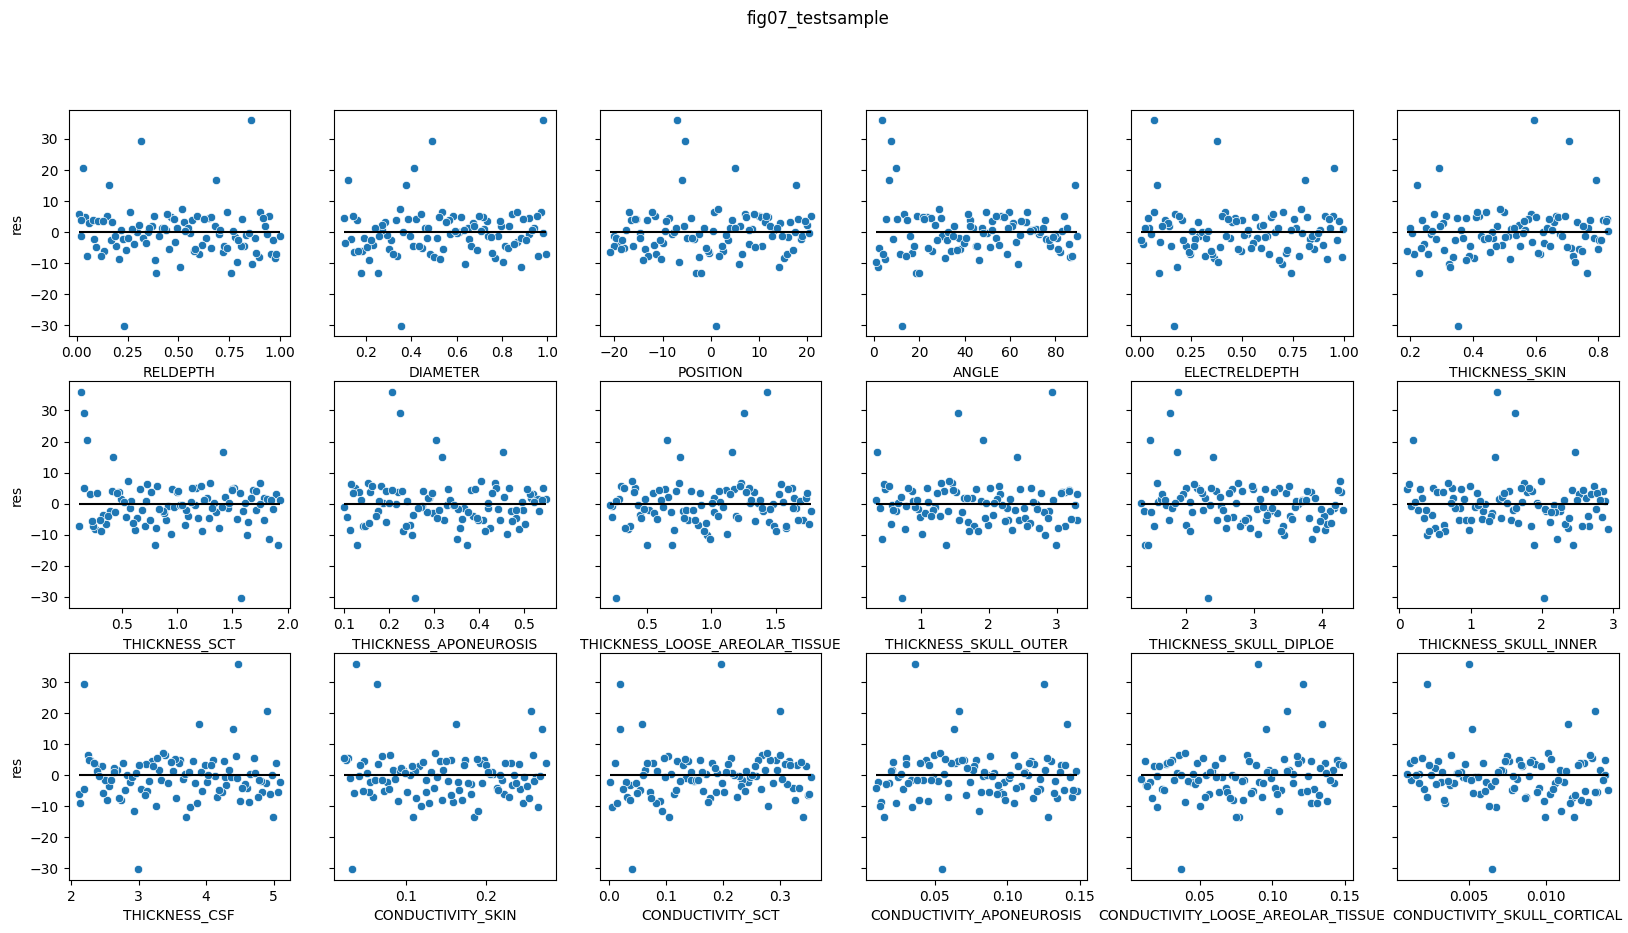

In [12]:
title = "fig07_testsample"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="res", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

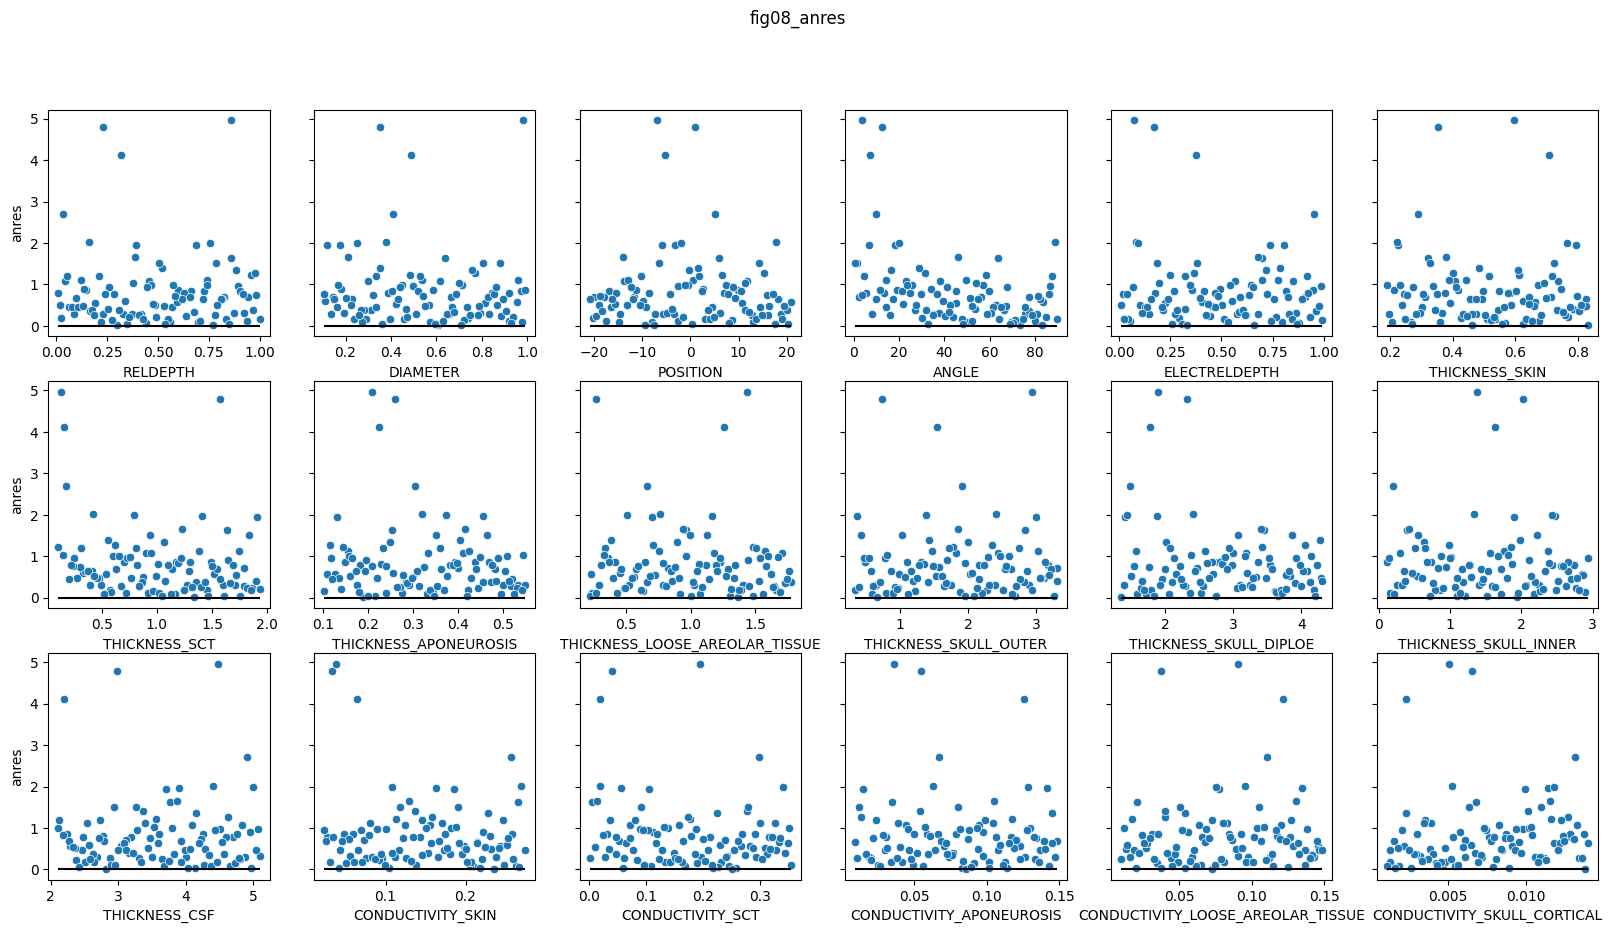

In [13]:
title = "fig08_anres"

fig, axs = plt.subplots(3, 6, figsize=(20, 10), sharey=True)
axs: List[plt.Axes] = axs.flatten()
for c, ax in zip(variables_train[1:-1], axs):
    sns.scatterplot(data, x=c, y="anres", ax=ax)
    ax.set_xlabel(c)
    ax.hlines(0.0, data[c].min(), data[c].max(), color="black")
plt.suptitle(title)
plt.show()

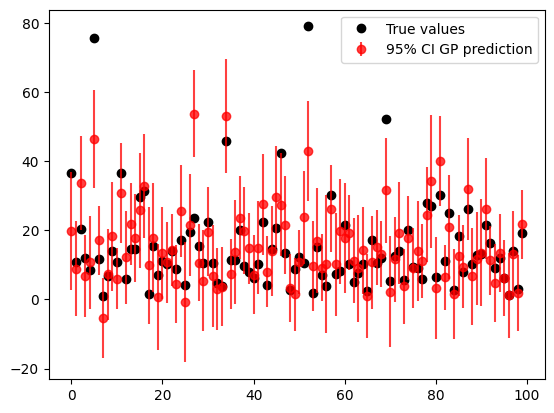

In [14]:
# sorted_idx = np.argsort(y)
# y = y[sorted_idx]
# y_hat = y_hat[sorted_idx]
# std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
# plt.ylim(-200, 1420)
plt.legend()

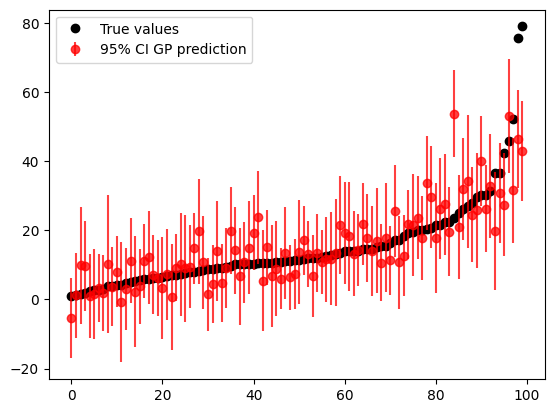

In [15]:
sorted_idx = np.argsort(y)
y = y[sorted_idx]
y_hat = y_hat[sorted_idx]
std = std[sorted_idx]
plt.plot(y, "ko", label="True values")
plt.errorbar(
    range(len(y_hat)),
    y_hat,
    yerr=2 * std,
    fmt="o",
    color="red",
    alpha=0.75,
    label="95% CI GP prediction",
)
# plt.ylim(-200, 1420)
plt.legend()

In [16]:
np.mean(np.abs(y - y_hat))

np.float64(5.372359280389)

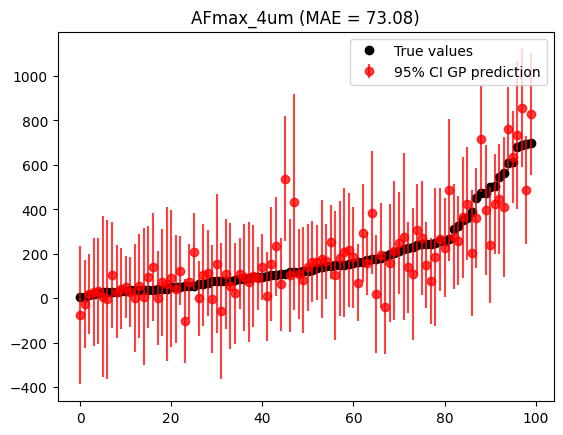

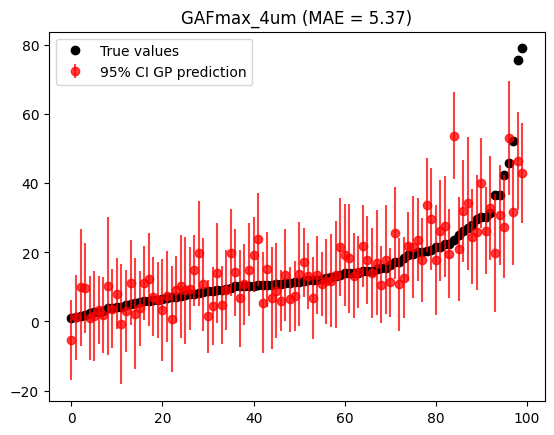

In [19]:
def plot_prediction_vs_truth(RESPONSE):
    y = funs_data_processing.get_results(TEST_SAMPLES_FILE, RESPONSE)
    y_hat = funs_data_processing.get_results(tmp_folder / "predictions.dat", RESPONSE)
    std = np.sqrt(
        funs_data_processing.get_results(
            tmp_folder / "variances.dat", RESPONSE + "_variance"
        )
    )
    y_tilde = (y - y_hat) / std

    sorted_idx = np.argsort(y)
    y = y[sorted_idx]
    y_hat = y_hat[sorted_idx]
    std = std[sorted_idx]
    plt.plot(y, "ko", label="True values")
    plt.errorbar(
        range(len(y_hat)),
        y_hat,
        yerr=2 * std,
        fmt="o",
        color="red",
        alpha=0.75,
        label="95% CI GP prediction",
    )
    # plt.ylim(-200, 1420)
    plt.legend()
    plt.title(f"{RESPONSE} (MAE = {np.mean(np.abs(y - y_hat)):.2f})")
    plt.show()


plot_prediction_vs_truth("AFmax_4um")
plot_prediction_vs_truth("GAFmax_4um")